<a href="https://colab.research.google.com/github/rchartra/CutView/blob/master/ML_Tutorial_Part2_Phytoplankton.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine Learning (ML)

## Part II: Deep Learning using Convolutional Neural Networks

<img src="https://github.com/gmanuch/DataScienceOceanography/blob/main/Tutorials2023/ML/plankton%20diagram.png?raw=1" width=1000/>

This tutorial is part of our Machine Learning day. It demonstrates how to build a deep learning model and prepare an input data pipeline for a real-world ocean science problem -- automatically labelling images of plankton with the correct species label!  

### Estimated tutorial time: 1.5 hours

## Tutorial goals
- Python Skills
    - Work with TensorFlow and Keras packages for machine learning
    - Load and process large number of images from original source
    - Visualise data to make sure it is appropriate for feeding to the deep learning model
    - Calculate confusion matrix
- ML knowledge
    - Learn about supervised learning for image classification
    - Learn how to deal with class imbalance in the training data
    - Learn how to build a simple Convolutional Neural Network (CNN) model
    - Learn how to prepare image data for input into a CNN
    
## Data

- Imaging FlowCytobot (IFCB) is an autonomous submersible flow cytometer developed at the Woods Hole Oceanographic Institute (WHOI). IFCB automatically photographs (through a microscope) plankton from seawater sizes down to around 10 microns. The instrument has been deployed at the Martha's Vineyard Coastal Observatory at a depth of 4m since 2006, providing a continuous time series of plankton images over multiple years. These data are important for studying the structure of ocean ecosystems. There are far too many images for human experts to hand label the species of every plankton, so an automated labelling procedure is necessary. To help train machine learning models for this task, scientists at WHOI produced a dataset of over 3.5 million images that were hand-labelled by experts: https://github.com/hsosik/WHOI-Plankton.

- We pre-downloaded the image files from the website using the script __download_plankton.py__ to save time. The first part of this notebook will show how to prepare a dataset from this large quantity of image files, but we also saved a file __processed_dataset.??__ to save time, so you can go ahead and just load this file if you want to try out different deep learning models on the pre-processed data.




    
## Reading

Gonzalez, P., et al., 2019, Automatic plankton quantification using deep features, Journal of Plankton Research (https://doi.org/10.1093/plankt/fbz023).

# Let's start!

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import image
import os
# os.environ["CUDA_VISIBLE_DEVICES"]="-1" # uncomment to disable GPU
import tensorflow as tf
from tensorflow import keras
import pandas as pd

## Data, data, data -- so much data!

The data consists of thousands of images (.png files) of plankton taken using IFCB. Each plankton image has been classified by an expert. The data is organised into directories for each, each containing subdirectories for each class. First, let's read through the directories to list all the classes in the dataset.

In [ ]:
data_dir = "/content/drive/MyDrive/Datasets2023/WHOI-Plankton"

In [ ]:
from zipfile import ZipFile

for filename in os.listdir(data_dir):
  if filename[-4:] == ".zip":
    with ZipFile(data_dir + "/" + filename, 'r') as f:
        f.extractall()

In [ ]:
years = ['2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014']

all_years = {}

for year in years:
  dir_name = "/content/" + year
  a=!find  "{dir_name}" -name "*.png"

  species = [x[14: x.find("/", 15)] for x in a]
  years = [x[9:13] for x in a]
  days = [x[-20:-17] for x in a]
  hours = [x[-16:-14] for x in a]
  minutes = [x[-14:-12] for x in a]
  seconds = [x[-12:-10] for x in a]

  data = {"Species":species, "Years":years, "Days":days, "Hours":hours, "Minutes":minutes, "Seconds":seconds}
  df = pd.DataFrame.from_dict(data)

  all_years[year] = df

In [ ]:
print(all_years['2011'])

                  Species Years Days Hours Minutes Seconds
0       Emiliania_huxleyi  2011  326    17      07      12
1       Emiliania_huxleyi  2011  326    17      30      24
2       Emiliania_huxleyi  2011  346    20      04      22
3       Emiliania_huxleyi  2011  326    19      26      26
4       Emiliania_huxleyi  2011  326    16      20      47
...                   ...   ...  ...   ...     ...     ...
439189            Paralia  2011  060    16      46      16
439190            Paralia  2011  240    16      28      44
439191            Paralia  2011  001    16      50      30
439192            Paralia  2011  187    16      40      58
439193            Paralia  2011  240    17      15      08

[439194 rows x 6 columns]


In [ ]:
species = [x[14: x.find("/", 15)] for x in a]
years = [x[9:13] for x in a]
days = [x[-20:-17] for x in a]
hours = [x[-16:-14] for x in a]
minutes = [x[-14:-12] for x in a]
seconds = [x[-12:-10] for x in a]

In [ ]:
data = {"Species":species, "Years":years, "Days":days, "Hours":hours, "Minutes":minutes, "Seconds":seconds}
df = pd.DataFrame.from_dict(data)

In [ ]:
print(df)

                 Species Years Days Hours Minutes Seconds
0            zooplankton  2007  304    00      21      52
1            zooplankton  2007  318    18      46      58
2            zooplankton  2007  101    18      26      57
3            zooplankton  2007  129    00      47      32
4       Asterionellopsis  2007  347    00      43      16
...                  ...   ...  ...   ...     ...     ...
289015           Paralia  2007  027    00      07      18
289016           Paralia  2007  309    19      17      46
289017           Paralia  2007  114    18      52      22
289018           Paralia  2007  046    16      54      34
289019           Paralia  2007  343    21      12      57

[289020 rows x 6 columns]


In [ ]:
print(a[0])
print(a[0][14: a[0].find("/", 15)])
print(a[0][-12:-10])

/content/2006/Emiliania_huxleyi/IFCB1_2006_354_185546_02022.png
Emiliania_huxleyi
46


In [ ]:
data_dir = "/content/"

def png_filenames(year,data_dir):

    dir_name=data_dir + str(year) + '/'
    print(dir_name)

    a=!find  "{dir_name}" -name "*.png"   # use a linux command to find all png files in the folder; it returns a list with paths of *png files

    a=np.array(a)                         # make the list into an numpy array for more convenient operations
    print(a)

    exclude_list=np.array(['mix','mix_elongated','detritus','bad']) # define a set of phytoplankton classes to exclude from data

    class_name=a.copy();

    for i in range(len(a)):
        class_name[i]=a[i].replace(dir_name,'').split('/', 1)[0]    # use the path name to extract the class. The images are organized in folders as /year/class_name/*.png
        if np.sum(exclude_list==class_name[i]):
            class_name[i]="";

    a=a[class_name!=""]                        # remove the empty data from excluded classes
    class_name=class_name[class_name!=""]

    return a, class_name                       # return pathnames and class_name

In [ ]:
#extract png file paths for a range of years

class_name=np.array([])
png_names=np.array([])
for year in np.arange(2006, 2007): # data available 2006-2014
        a, b = png_filenames(year,data_dir)
        png_names=np.concatenate((png_names, a), axis=0)    #concatenate the data from different years
        class_name=np.concatenate((class_name, b), axis=0)

NameError: ignored

In [ ]:
classes, counts = np.unique(class_name, return_counts=True)               # identify the unique classes and associated number of examples
classes_sorted=[x for y, x in sorted(zip(counts,classes),reverse=True)]   # sort classes by the number of examples
counts_sorted=sorted(counts,reverse=True)

Let's take a look at how many images we have for different species':

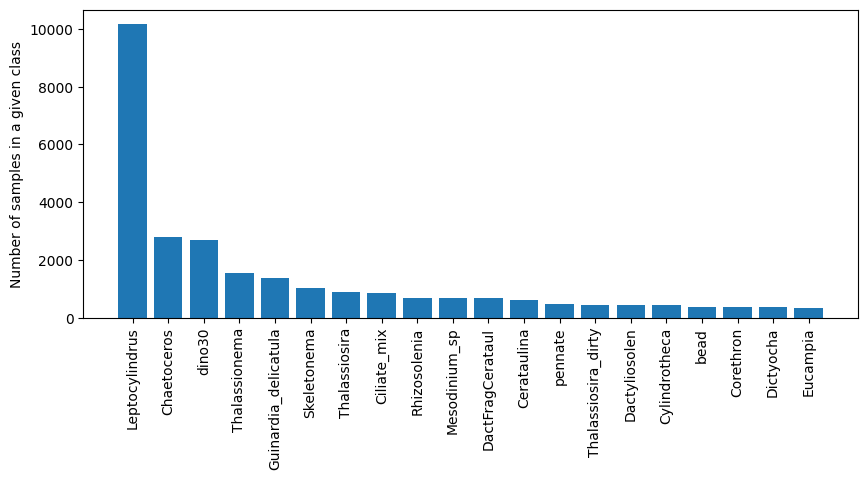

In [ ]:
plt.figure(figsize=(10,4))
plt.bar(classes_sorted[:20], counts_sorted[:20]) #plot top 10 most observed classes
plt.xticks(rotation='vertical')
plt.ylabel('Number of samples in a given class');

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Let's take a look at some of those images, run this cell to see 3 random images from the data set:

NameError: ignored

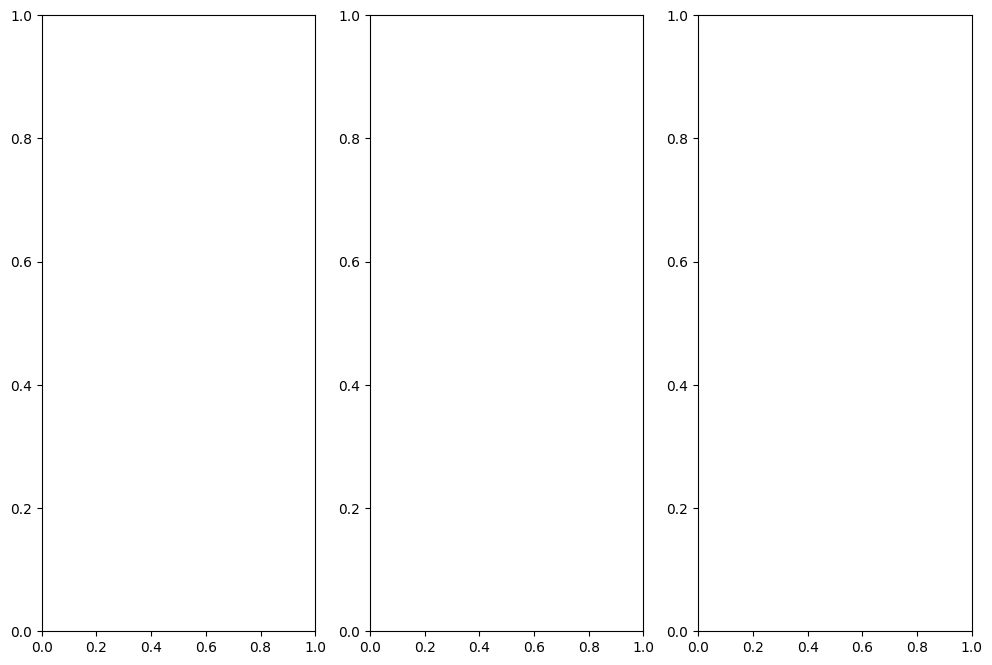

In [ ]:
fig, axs = plt.subplots(1,3, figsize = (12,8))
for i in range(3):
    N=np.random.randint(len(png_names))
    im=image.imread(png_names[N])
    axs[i].imshow(im, cmap = 'gray', vmin = 0, vmax = 1) # the black and white images have pixel values ranging from 0 (black) to 1 (white)
    axs[i].set_title(class_name[N]);

One thing that jumps out straight away is that the images come in very different shapes and sizes. The deep learning model we'll build later requires fixed inputs which aren't too large (to limit the memory requirements during training). To do this, let's take a square cropped image from the center of each image with fixed size, say, 64 pixels. If either dimension of the image is less than 64 we'll pad the image with zeros (i.e. black pixels)

In [ ]:
#crop only the center n by n pixel image from the original data, and fill the image to an n by n size if it is smaller than that
def crop_center(im,n):

    nx=im.shape[1]
    ny=im.shape[0]

    if nx<n:
        imm=np.zeros((ny,n))
        imm[:ny,:nx]=im
        im=imm

    nx=im.shape[1]
    ny=im.shape[0]

    if ny<n:
        imm=np.zeros((n,nx))
        imm[:ny,:nx]=im
        im=imm

    nx=im.shape[1]
    ny=im.shape[0]

    im=im[ (ny//2-n//2):(ny//2+n//2),(nx//2-n//2):(nx//2+n//2)]

    return im

Let's see how those cropped images look...

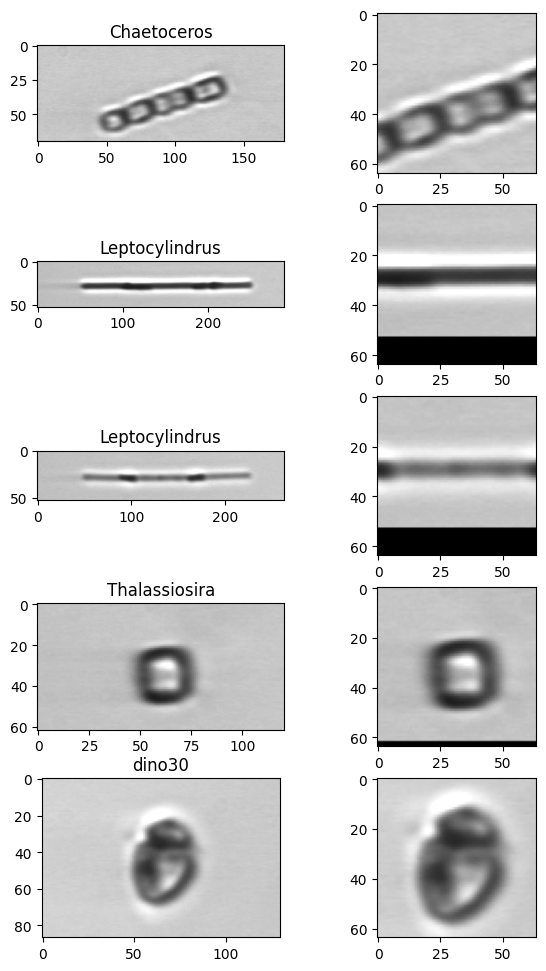

In [ ]:
fig, axs = plt.subplots(5,2, figsize = (7,12))
for i in range(5):
    N=np.random.randint(len(png_names))
    im=image.imread(png_names[N])
    axs[i][0].imshow(im, cmap = 'gray', vmin = 0, vmax = 1)
    im=crop_center(im,64)
    axs[i][1].imshow(im, cmap = 'gray', vmin = 0, vmax = 1)
    axs[i][0].set_title(class_name[N]);

We definitely lose some information by taking these small crops from the images, but there should hopefully still be enough distinctive features within the cropped images for our deep learning model to recognise the species!

Now that we've explored the data a little, let's go ahead and load in lots of images (extracting square crops from each) into numpy arrays.

In [ ]:
def load_images(a,class_name,keep_classes):

    print('Loading the following classes:', keep_classes);
    class_name_keep=class_name.copy()

    a_keep=a.copy()

    for i in range(len(a)):
        if np.sum(keep_classes==class_name_keep[i])==0:
            class_name_keep[i]="";

    a_keep=a_keep[class_name_keep!=""]
    class_name_keep=class_name_keep[class_name_keep!=""]


    Nsamples=len(a_keep)
    IMAGES=np.zeros((Nsamples,64,64))
    IM_class=class_name_keep.copy()

    for i in range(Nsamples):
        im=image.imread(a[i])
        IMAGES[i,:,:]=crop_center(im,64)


    class_labels=np.arange(len(IM_class))
    for i in range(len(keep_classes)):
        class_labels[IM_class==keep_classes[i]]=i

    return IMAGES, IM_class, class_labels

Even with this smaller set of classes, there is a large 'class imbalance' (i.e. there are many more examples of some classes than of others, go back to the histogram we plotted and you'll see there are lots of leptocylindrus images compared to the others!). A CNN trained on this dataset is likely to perform poorly in classifying the least frequently occuring class, as it will have 'seen' fewer examples compared to the other classes.

There are a number of ways to deal with class imbalance (https://www.analyticsvidhya.com/blog/2020/07/10-techniques-to-deal-with-class-imbalance-in-machine-learning/), here we'll use 'undersampling'. This means we'll remove samples from the frequently occuring classes until all classes have the same number of samples as the least frequently occuring, thus creating a smaller but balanced data set.

In [ ]:
def balance_class_samples(png_names,class_name,keep_classes):

    # n_min=np.sum(class_name==keep_classes[-1])
    # limit number of images per class to 1000 to run on this server
    n_min=1000

    png_names_balanced=np.array([])
    class_name_balanced=np.array([])

    for i in range(len(keep_classes)):
        png_names_i=png_names[class_name==keep_classes[i]]
        class_name_i=class_name[class_name==keep_classes[i]]

        rand_ind=np.random.randint(0,len(png_names_i)-1,n_min);
        rand_ind=np.sort(rand_ind)
        rand_ind=np.arange(n_min)

        png_names_i=png_names_i[rand_ind]
        class_name_i=class_name_i[rand_ind]

        png_names_balanced=np.concatenate((png_names_balanced, png_names_i), axis=0)
        class_name_balanced=np.concatenate((class_name_balanced, class_name_i), axis=0)

    return png_names_balanced,class_name_balanced

In [ ]:
keep_classes=np.array(classes_sorted[:10])

png_names_balanced,class_name_balanced =balance_class_samples(png_names,class_name,keep_classes)

IndexError: ignored

In [ ]:
%%time

IMAGES, IM_class, class_labels = load_images(png_names_balanced,class_name_balanced,keep_classes)

Save the processed data for faster loading in future:

In [ ]:
#np.save('IMAGES.npy', IMAGES)
#np.save('IM_class.npy', IM_class)
#np.save('class_labels.npy', class_labels)

Load processed data for faster loading:

In [ ]:
%%time
IMAGES = np.load('/content/drive/MyDrive/Datasets2023/WHOI-Plankton/IMAGES.npy')
IM_class = np.load('/content/drive/MyDrive/Datasets2023/WHOI-Plankton/IM_class.npy')
class_labels = np.load('/content/drive/MyDrive/Datasets2023/WHOI-Plankton/class_labels.npy')
keep_classes = np.array(['Leptocylindrus', 'Chaetoceros', 'dino30', 'Thalassionema',
       'Guinardia_delicatula', 'Skeletonema', 'Thalassiosira',
       'Ciliate_mix', 'Rhizosolenia', 'Mesodinium_sp'])

CPU times: user 89 ms, sys: 3.53 s, total: 3.62 s
Wall time: 14 s


# Deep Learning

Now that we have the desired data loaded in an appropriate format, it's time to design a deep neural network. We will explore Convolutional Neural Networks (CNNS), which are some of the most powerful neural network architectures for analysis of images. You can read up on the basic ideas behind a CNN here: https://levelup.gitconnected.com/a-gentle-introduction-to-convolutional-neural-networks-98923560578f. This type of neural network was pioneered by Yann LeCun and others in the 1990's to recognise hand-written ZIP codes on mail envelopes (their original paper: http://vision.stanford.edu/cs598_spring07/papers/Lecun98.pdf , it's very long so you don't have to read all of it!). In the decades since, CNNs have exploded in popularity and have been developed for all sorts of state-of-the-art computer vision applications.

We won't have time to cover them today, but here are just a few of the other popular neural network architectures used by researchers today: Multilayer Perceptrons (MLPs), Transformer Networks, Generative Adversarial Networks (GANs), Long Short-Term Memory (LSTM), Graph Neural Networks, plus countless more!

Here, we'll have a go at developing a simple CNN to predict the species of our plankton images. We'll use the TensorFlow (https://www.tensorflow.org/api_docs) and Keras (https://keras.io/api/) APIs for building and training our neural network.

A CNN takes as input a tensor of shape (N_rows, N_cols, N_channels) representing an image. Since we're using black and white images, N_channels = 1 for our problem (N_channels = 3 for a colour image, corresponding to RGB).

So our input should have shape: (64,64,1), let's reshape our image data and call it X.

For the class labels, we'll use 'one-hot' encoding (https://en.wikipedia.org/wiki/One-hot#Machine_learning_and_statistics). So we replace the strings representing our class labels with vectors of length 10 (for the 10 classes) with a 1 in the vector entry corresponding to the right class label and 0 everywhere else. Our CNN will output a similar vector of length 10, with each entry corresponding to the probability the network predicts for the image to belong to each class.

Luckily for us, the Keras API can create this one-hot encoding for us!

In [ ]:
# reshape the images for input to CNN

X= np.expand_dims(IMAGES, axis=3)
# create the one-hot encoding of the training labels
Y = keras.utils.to_categorical(class_labels, len(keep_classes))

Now we'll define a simple CNN model with 5 convolutional layers, each followed by a max pooling layer. This sequence of layers allows the network to recognise features from the images independent of where within the image they are (if a plankton is moved 2 microns to the left it's still the same plankton!). These features are aggregated together for the whole image by the GlobalAveragePooling layer before being passed to a fully connected ('Dense') layer to predict the class probabilities from the image features. The weights in the fully connected layer are randomly dropped (Dropout) during training to reduce the risk of overfitting.

During training, the network seeks to minimise its loss function. Here, we use 'categorical cross entropy' which takes a smaller value when the predicted probability approaches 100% for the correct class: $$loss = - \sum_{i=1}^{N}y_i\text{log}(p_i),$$
where $N$ is the number of classes (10 in our case), $y_i$ is the true one-hot encoding value for the i-th class (0 or 1), and $p_i$ is the network's predicted probability for that class.

In [ ]:
# define a simple CNN model to classify plankton types
def create_cnn_model(input_shape, output_shape):

    x = keras.layers.Input(shape=input_shape)

    y = keras.layers.Conv2D(8, (3,3), activation='relu', padding='same')(x) # add a convolutional layer with a ReLU activation
    y = keras.layers.MaxPooling2D(pool_size=(2,2))(y)     # add a max pooling layer

    y = keras.layers.Conv2D(16, (3,3), activation='relu', padding='same')(y)
    y = keras.layers.MaxPooling2D(pool_size=(2,2))(y)

    y = keras.layers.Conv2D(32, (3,3), activation='relu', padding='same')(y)
    y = keras.layers.MaxPooling2D(pool_size=(2,2))(y)

    y = keras.layers.Conv2D(64, (3,3), activation='relu', padding='same')(y)
    y = keras.layers.MaxPooling2D(pool_size=(2,2))(y)

    y = keras.layers.Conv2D(128, (3,3), activation='relu', padding='same')(y)

    y = keras.layers.GlobalAveragePooling2D()(y)

    y = keras.layers.Dropout(0.5)(y)

#    y = keras.layers.Dense(128, activation='relu')(y)

    y = keras.layers.Dense(output_shape, activation='softmax')(y)     # add final output layer with a softmax activation

    model = keras.models.Model(inputs=x, outputs=y)

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [ ]:
CNN = create_cnn_model(input_shape=(64,64,1), output_shape=len(keep_classes))
# take a look at how the image tensor changes shape as it passes through the CNN:
CNN.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 64, 64, 1)]       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 64, 64, 8)         80        
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 32, 32, 8)        0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 32, 32, 16)        1168      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 16, 16, 16)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 16, 16, 32)        4640

Our CNN is now ready to train! To prevent overfitting (https://en.wikipedia.org/wiki/Overfitting), we need to split our dataset into a training set and a validation set. The validation set will only be used to monitor the progress during training (the network parameters aren't adjusted in response to the performance on the validation data) and to test the network's accuracy at the end.

After splitting the data, we'll then train our model. The number of epochs refers to the number of times the model sees the full training dataset during training. The batch_size refers to the number of examples passed to the model between updates of the network parameters.

In [ ]:
%%time
# fraction of the dataset to use for validation
val_split=0.2

# randomly select the val indices to ensure random mix of classes
ind_val= (np.random.rand(X.shape[0])<val_split)

X_val=X[ind_val]
Y_val=Y[ind_val]

class_labels_val=class_labels[ind_val]

# remaining data goes in the training dataset
X_train=X[~ind_val]
Y_train=Y[~ind_val]

# train the model, and save the progress to hist (hist will be a dictionary)
n_epochs = 20
hist = CNN.fit(x = X_train, y = Y_train, epochs=n_epochs, batch_size=512, validation_data=(X_val,Y_val))

Epoch 1/20
102/102 [==============================] - 6s 36ms/step - loss: 1.8611 - accuracy: 0.2675 - val_loss: 1.4816 - val_accuracy: 0.4076
Epoch 2/20
102/102 [==============================] - 3s 25ms/step - loss: 1.4322 - accuracy: 0.4289 - val_loss: 1.2694 - val_accuracy: 0.5154
Epoch 3/20
102/102 [==============================] - 2s 23ms/step - loss: 1.2999 - accuracy: 0.5019 - val_loss: 1.1796 - val_accuracy: 0.5555
Epoch 4/20
102/102 [==============================] - 2s 22ms/step - loss: 1.1891 - accuracy: 0.5538 - val_loss: 1.0751 - val_accuracy: 0.6064
Epoch 5/20
102/102 [==============================] - 2s 23ms/step - loss: 1.1148 - accuracy: 0.5883 - val_loss: 1.0629 - val_accuracy: 0.6001
Epoch 6/20
102/102 [==============================] - 2s 23ms/step - loss: 1.0643 - accuracy: 0.6080 - val_loss: 0.9612 - val_accuracy: 0.6499
Epoch 7/20
102/102 [==============================] - 3s 26ms/step - loss: 1.0137 - accuracy: 0.6290 - val_loss: 0.9360 - val_accuracy: 0.6641

Let's see how we did!

We'll use accuracy as our performance metric. This is the average per-class effectiveness of the class predictor, i.e. $\frac{TP+TN}{TP+TN+FP+FN}$, where TP = true positive, TN = true negative, FP = false positive, and FN = false negative. So the accuracy would tend to 1 for a perfect predictor.

If we randomly guess classes, we should expect the accuracy to be $1/N = 0.1$. So we can use this as a baseline, if we do worse than this then we really messed up!

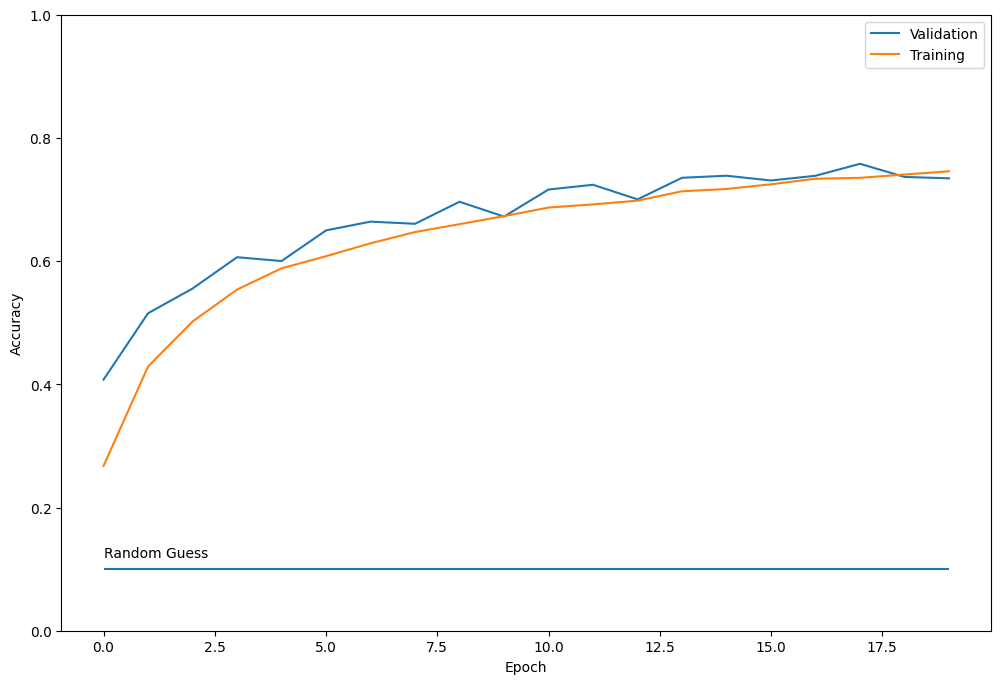

In [ ]:
# plot how the accuracy on the training and validation datasets evolved during training
plt.figure(figsize=(12,8))
plt.plot(hist.history['val_accuracy'],label='Validation')
plt.plot(hist.history['accuracy'],label='Training')
plt.ylim([0,1])
plt.hlines(0.1,0,n_epochs-1)
plt.annotate('Random Guess',(0, 0.12))
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy');

**Bonus question to think about at home:** We expect the training accuracy to be higher than the validation accuracy, but for the first few epochs the validation accuracy appears to be higher. Can you explain why?

*hint:* It's to do with when in an epoch these accuracies are calculated...

To get a better feel for how the network is doing, let's randomly predict class labels for images from the training data and compare the predicted probabilities to the real labels:

1/1 [==============================] - 0s 18ms/step


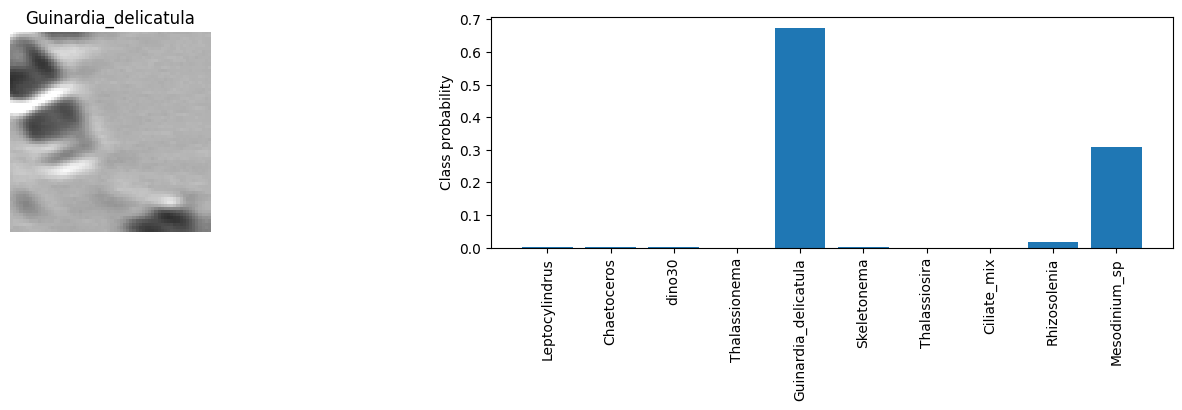

In [ ]:
N=np.random.randint(0,X_val.shape[0]) # test some random image

x=np.expand_dims(X_val[N], axis=0)
predictions = CNN.predict(x)

class_name_true=keep_classes[Y_val[N,:]==1][0]

plt.figure(figsize=(15,3))
plt.subplot(1,5,1)
plt.imshow(x[0,:,:,0], cmap = 'gray', vmin = 0, vmax = 1)
plt.title(class_name_true)
plt.axis('off')

plt.subplot(1,5,(3,5))
plt.bar(keep_classes,predictions[0])
plt.xticks(rotation='vertical')
plt.ylabel('Class probability');
ax=plt.gca()
ax.grid(False)


## Metrics of accuracy: confusion matrix

We can look at which classes are being mistaken for one another by the network by plotting a 'confusion matrix'. The rows correspond to the true classes while the columns correspond to the predicted classes. So __confusion_matrix[i,j]__ = the number of examples with true class i, for which the class j was predicted. Entries along the diagonal correspond to correct predictions.

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
predictions = CNN.predict(X_val)
predictions_class=np.argmax(predictions, axis=1)

403/403 [==============================] - 1s 3ms/step


In [ ]:
conf_mat=confusion_matrix(class_labels_val, predictions_class)

conf_mat=conf_mat/ conf_mat.sum(axis=1, keepdims=True); # normalizing by the total number of samples
conf_mat=(conf_mat*100).round().astype(int)  # in per cent now, which is good for plotting!
# i.e. the % of the samples with true class i for which class j was predicted, so each row adds to 100%

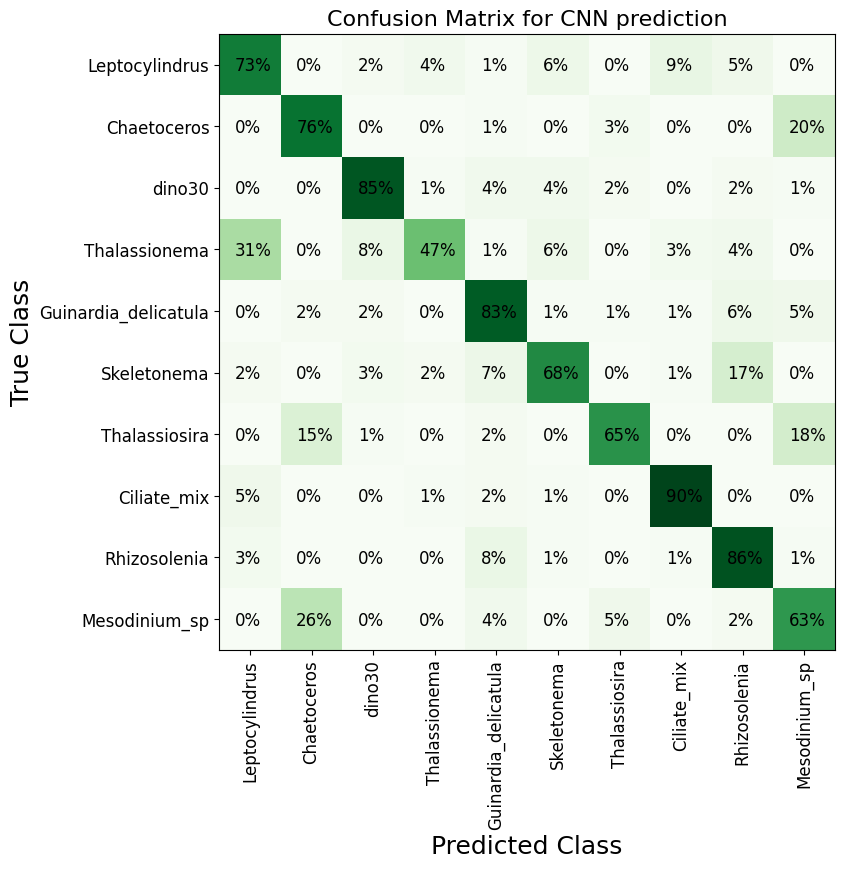

In [ ]:
n=len(keep_classes)

plt.figure(figsize=(8,8))
plt.imshow(conf_mat, cmap='Greens',aspect=1)
ax=plt.gca()
plt.xticks(range(n), keep_classes, rotation='vertical',fontsize=12)
plt.yticks(range(n), keep_classes, fontsize=12)
plt.xlabel('Predicted Class', fontsize = 18)
plt.ylabel('True Class', fontsize = 18)
ax.grid(False)
plt.title('Confusion Matrix for CNN prediction',fontsize=16)
for i in range(n):
    for j in range(n):
        plt.text(i-0.25,j+0.1, str(conf_mat[j,i])+'%', fontsize=12);

As you can see, the network does much better for some classes than others!

## In-class exercise: Try adjusting the CNN complexity and seeing how this affects the performance and training

Try reducing the number of layers and number of filters in each convolutional layer to see what effect this has on the performance. We'll keep our original model saved as CNN, and create a new model (CNN_simple) then compare the performance of the two models.

In [ ]:
def create_CNN_simple(input_shape, output_shape):
    # LEAVE THIS LAYER UNCHANGED:
    x = keras.layers.Input(shape=input_shape)

    #############################################
    # EDIT THESE LINES:

    # Conv2D syntax: Conv2D(number of filters, filter size, activation function, image padding scheme)
    # try reducing the number of filters in the layers
    y = keras.layers.Conv2D(8, (3,3), activation='relu', padding='same')(x) # add a convolutional layer with a ReLU activation
    y = keras.layers.MaxPooling2D(pool_size=(2,2))(y)     # add a max pooling layer (REDUCES IMAGE HIEGHT AND WIDTH BY FACTOR OF 2)

    # try removing blocks like these next 2 lines:
    y = keras.layers.Conv2D(16, (3,3), activation='relu', padding='same')(y)
    y = keras.layers.MaxPooling2D(pool_size=(2,2))(y)

    y = keras.layers.Conv2D(32, (3,3), activation='relu', padding='same')(y)
    y = keras.layers.MaxPooling2D(pool_size=(2,2))(y)

    y = keras.layers.Conv2D(64, (3,3), activation='relu', padding='same')(y)
    y = keras.layers.MaxPooling2D(pool_size=(2,2))(y) # NOTE YOU CAN ONLY DIVIDE THE HEIGHT/WIDTH BY 2 SO MANY TIME BEFORE HEIGHT=WIDTH=1!

    y = keras.layers.Conv2D(128, (3,3), activation='relu', padding='same')(y)

    ############################################

    # LEAVE REST OF THE FUNCTION FROM HERE UNCHANGED
    y = keras.layers.GlobalAveragePooling2D()(y)

    y = keras.layers.Dropout(0.5)(y)

#    y = keras.layers.Dense(128, activation='relu')(y)

    y = keras.layers.Dense(output_shape, activation='softmax')(y)     # add final output layer with a softmax activation

    model = keras.models.Model(inputs=x, outputs=y)

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model
CNN_simple = create_CNN_simple(input_shape=(64,64,1), output_shape=len(keep_classes))
CNN_simple.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 64, 64, 1)]       0         
                                                                 
 conv2d_15 (Conv2D)          (None, 64, 64, 16)        160       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 32, 32, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 32, 32, 16)        2320      
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 16, 16, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 16, 16, 32)        4640

In [ ]:
# train the network
# train the model, and save the progress to hist (hist will be a dictionary)
n_epochs = 20
hist_simple = CNN_simple.fit(x = X_train, y = Y_train, epochs=n_epochs, batch_size=512, validation_data=(X_val,Y_val))

Epoch 1/20
102/102 [==============================] - 7s 36ms/step - loss: 1.9240 - accuracy: 0.2456 - val_loss: 1.6066 - val_accuracy: 0.4090
Epoch 2/20
102/102 [==============================] - 3s 30ms/step - loss: 1.4803 - accuracy: 0.4215 - val_loss: 1.3149 - val_accuracy: 0.4975
Epoch 3/20
102/102 [==============================] - 3s 28ms/step - loss: 1.2851 - accuracy: 0.5086 - val_loss: 1.1769 - val_accuracy: 0.5634
Epoch 4/20
102/102 [==============================] - 3s 27ms/step - loss: 1.1733 - accuracy: 0.5582 - val_loss: 1.0505 - val_accuracy: 0.6200
Epoch 5/20
102/102 [==============================] - 3s 27ms/step - loss: 1.0950 - accuracy: 0.5940 - val_loss: 1.0107 - val_accuracy: 0.6305
Epoch 6/20
102/102 [==============================] - 3s 28ms/step - loss: 1.0327 - accuracy: 0.6179 - val_loss: 0.9329 - val_accuracy: 0.6607
Epoch 7/20
102/102 [==============================] - 3s 30ms/step - loss: 0.9926 - accuracy: 0.6328 - val_loss: 0.9321 - val_accuracy: 0.6573

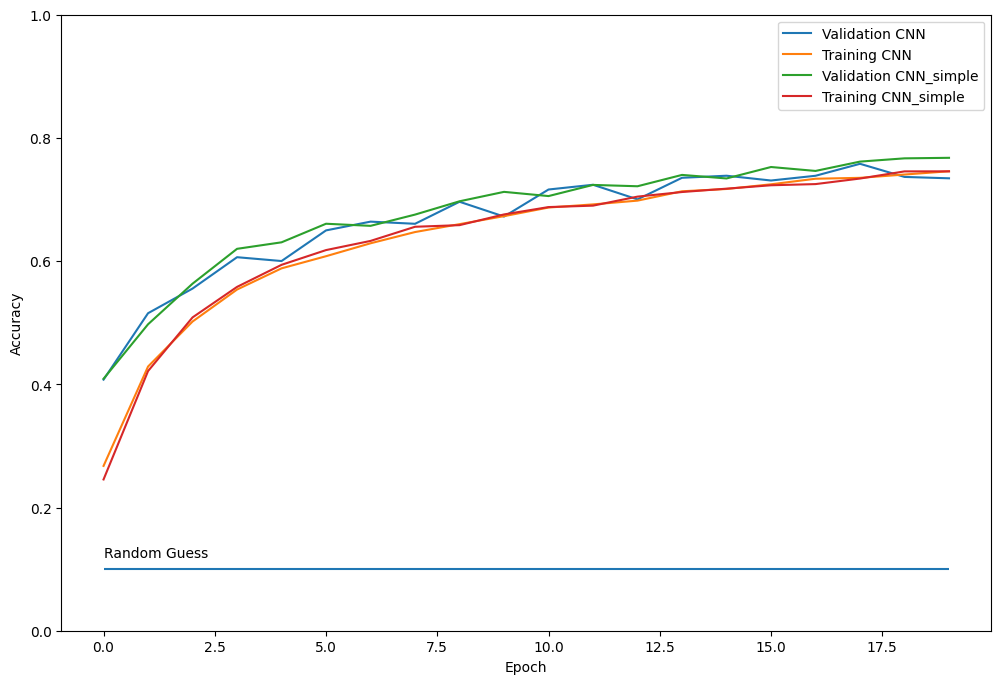

In [ ]:
# compare performance to original CNN model:
plt.figure(figsize=(12,8))
plt.plot(hist.history['val_accuracy'],label='Validation CNN')
plt.plot(hist.history['accuracy'],label='Training CNN')
plt.plot(hist_simple.history['val_accuracy'],label='Validation CNN_simple')
plt.plot(hist_simple.history['accuracy'],label='Training CNN_simple')
plt.ylim([0,1])
plt.hlines(0.1,0,n_epochs-1)
plt.annotate('Random Guess',(0, 0.12))
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy');

## Homework exercise: Try adding skip connections -- can you improve on the CNN model's accuracy?

He et al. 2015 (https://arxiv.org/abs/1512.03385?context=cs) showed that adding 'skip connections' to a CNN could greatly improve performance. This is known as 'residual learning', and CNNs with this structure are typically known as 'ResNets'.

In our simple CNN, the main building block of our network was:
```python
y = keras.layers.Conv2D(num_filters, (3,3), activation='relu', padding='same')(y)
y = keras.layers.MaxPooling2D(pool_size=(2,2))(y)
```
In ResNet, we'll replace this block with a residual learning block. In this type of block, we will add skip connections to allow some information to skip the convolution layers, before being recombined by adding it to the result of the convolutions.
Have a go at building one for yourself using the Keras API (https://keras.io/api/), then stack these blocks together to build a ResNet model (the functions you'll need are keras.layers.Conv2D(), keras.layers.BatchNormalization(), keras.layers.Activation()). Can you improve on the accuracy we gained with the `vanilla' CNN model?

Here's a diagram of what one of these blocks looks like:


<img align="left" src="https://github.com/gmanuch/DataScienceOceanography/blob/main/Tutorials2023/ML/resnet.png?raw=1" width=300/>


In [ ]:
def res_block(y,num_filters):
    # your code here
    return y

def create_ResNet(input_shape, output_shape):
    # LEAVE THIS LAYER UNCHANGED:
    x = keras.layers.Input(shape=input_shape)

    #############################################
    # ADD RESIDUAL LEARNING BLOCKS HERE:

    ############################################

    # LEAVE REST OF THE FUNCTION FROM HERE UNCHANGED
    y = keras.layers.GlobalAveragePooling2D()(y)

    y = keras.layers.Dropout(0.5)(y)

#    y = keras.layers.Dense(128, activation='relu')(y)

    y = keras.layers.Dense(output_shape, activation='softmax')(y)     # add final output layer with a softmax activation

    model = keras.models.Model(inputs=x, outputs=y)

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model
ResNet = create_ResNet(input_shape=(64,64,1), output_shape=len(keep_classes))
ResNet.summary()

In [ ]:
# train the network
# train the model, and save the progress to hist (hist will be a dictionary)
n_epochs = 20
hist_resnet = ResNet.fit(x = X_train, y = Y_train, epochs=n_epochs, batch_size=512, validation_data=(X_val,Y_val))

In [ ]:
# compare performance to original CNN model:
plt.figure(figsize=(12,8))
plt.plot(hist.history['val_accuracy'],label='Validation CNN')
plt.plot(hist.history['accuracy'],label='Training CNN')
plt.plot(hist_resnet.history['val_accuracy'],label='Validation ResNet')
plt.plot(hist_resnet.history['accuracy'],label='Training ResNet')
plt.ylim([0,1])
plt.hlines(0.1,0,n_epochs-1)
plt.annotate('Random Guess',(0, 0.12))
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy');